In [1]:
import matplotlib.pyplot as plt
import numpy as np
from material_models import GOH_fullyinc
from misc import predict, preprocessing, normalization
import tensorflow as tf
import pandas as pd
fsize=7
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize,fsize),
          'axes.labelsize': 1.75*fsize,
          'axes.titlesize': 1.75*fsize,
          'xtick.labelsize': 1.25*fsize,
          'ytick.labelsize': 1.25*fsize,
          'legend.fontsize': 1.25*fsize,
          'legend.title_fontsize': 1.25*fsize,
          'axes.titlepad': 10,
          'lines.linewidth': 1,
          'lines.markersize': 10,
          "mathtext.fontset": 'dejavuserif',
          'axes.labelpad': 5}
plt.rcParams.update(pltparams)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.2, 0.8, 2)))

n_offx = 61
n_offy = 61

## Make predictions

#### For line plots

In [2]:
dataset_name = 'P1C1_xy'
theta = 0
outputs = []
for model_name in ['P1C1_xy', 'P1C1_xys']:
    ndata, I1, I2, I4a, I4s, Psi_gt, X, Y, sigma_gt, F, C, C_inv  = preprocessing(dataset_name, theta1=theta)
    sigma_pr, _,_,_,_, Psi_pr = predict(model_name, dataset_name, impose_convexity=True, theta1=theta)
    GOH = GOH_fullyinc(X, 9.86876414e-04, 5.64353050e-01, 7.95242698e+01, 2.94747207e-01, 1.57079633e+00)

    sigma_GOH = GOH.s(X)
    Psi_GOH = GOH.U(X)

    outputs.append([X, Psi_gt, Psi_pr, Psi_GOH, sigma_gt, sigma_pr, sigma_GOH])

##### Print errors:

In [3]:
errors = []
gtstresses = [outputs[0][4], outputs[1][4]]
dnnstresses = [outputs[0][5], outputs[1][5]]
gohstresses = [outputs[0][6], outputs[1][6]]
for sigma_gt, sigma_pr in zip(gtstresses, dnnstresses):
    error = np.zeros(sigma_gt.shape[0])
    for i in range(sigma_gt.shape[0]):
        for j in range(3):
            for k in range(3):
                error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
        error[i] = np.sqrt(error[i])
    error = np.mean(error)*1000 #MPa -> kPa
    errors.append(error)
print('DNN Errors (Single fidelity & Multifidelity):')
print(errors)

errors = []
gtstresses = [outputs[0][4], outputs[1][4]]
dnnstresses = [outputs[0][5], outputs[1][5]]
gohstresses = [outputs[0][6], outputs[1][6]]
for sigma_gt, sigma_pr in zip(gtstresses, gohstresses):
    error = np.zeros(sigma_gt.shape[0])
    for i in range(sigma_gt.shape[0]):
        for j in range(3):
            for k in range(3):
                error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
        error[i] = np.sqrt(error[i])
    error = np.mean(error)*1000 #MPa -> kPa
    errors.append(error)
print('GOH Errors (Single fidelity & Multifidelity):')
print(errors)

DNN Errors (Single fidelity & Multifidelity):
[5.125719983122416, 12.813182544102958]
GOH Errors (Single fidelity & Multifidelity):
[22.54321423047606, 22.54321423047606]


#### For contour figures

In [4]:
dataset_name = 'contour_dataset'
theta = 0
contourdata = []
for model_name in ['P1C1_xy', 'P1C1_xys']:
    ndata, I1, I2, I4a, I4s, Psi_gt, X, Y, sigma_gt, F, C, C_inv  = preprocessing(dataset_name, theta1=theta)
    sigma_pr, _,_,_,_,Psi_pr = predict(model_name, dataset_name, impose_convexity=True, theta1=theta)
    GOH = GOH_fullyinc(X, 9.86876414e-04, 5.64353050e-01, 7.95242698e+01, 2.94747207e-01, 1.57079633e+00)

    sigma_gt = GOH.s(X)
    Psi_gt = GOH.U(X)

    Psi_err = np.abs(Psi_gt-Psi_pr)
    sigma_x_err = np.abs(sigma_gt[:,0,0]-sigma_pr[:,0,0])
    sigma_y_err = np.abs(sigma_gt[:,1,1]-sigma_pr[:,1,1])

    Psi_err = Psi_err.reshape(20,20)
    sigma_x_err = sigma_x_err.reshape(20,20)
    sigma_y_err = sigma_y_err.reshape(20,20)
    lm1 = X[:,0].reshape(20,20)
    lm2 = X[:,1].reshape(20,20)
    contourdata.append([lm1, lm2, Psi_err, sigma_x_err, sigma_y_err])

## Generate the figure

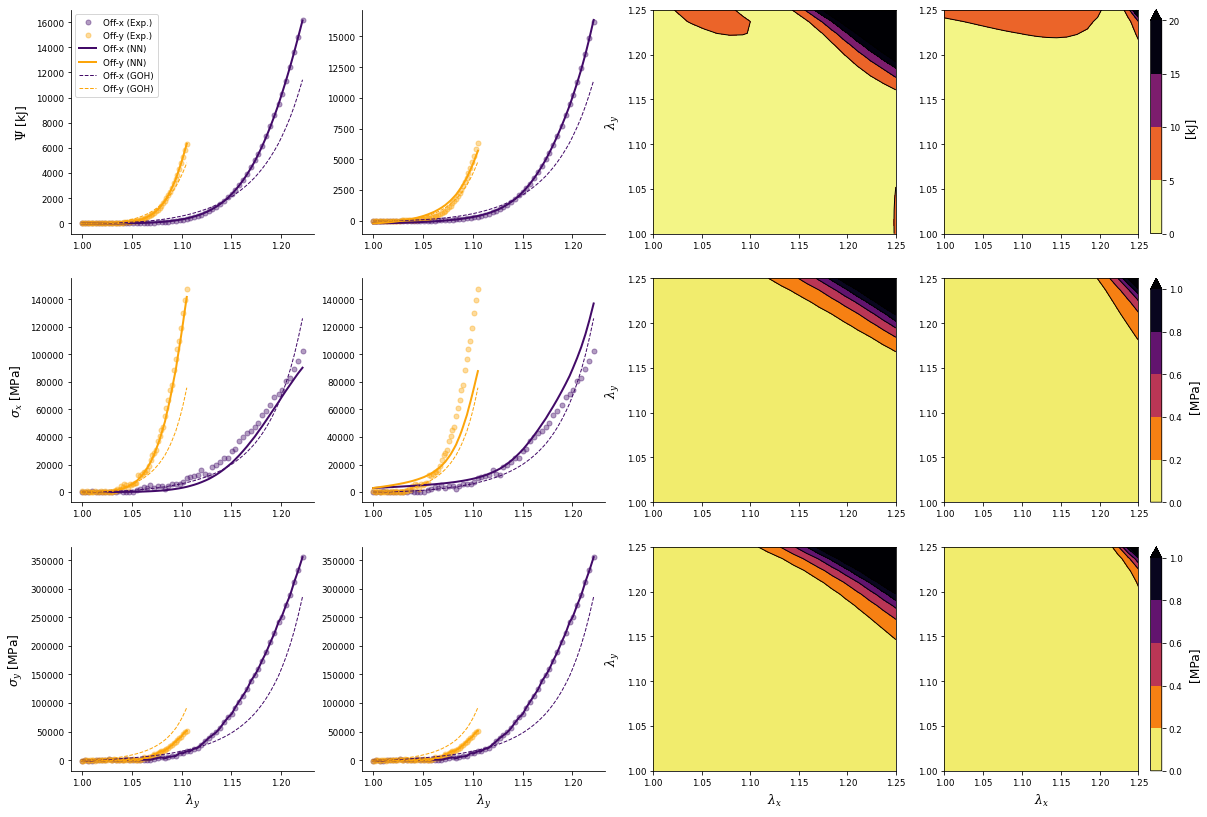

In [5]:
fig, axi = plt.subplots(3,4, figsize=(20,14))
nntypes = ['unaugmented','augmented']

for i in range(2):
    X, Psi_gt, Psi_pr, Psi_GOH, sigma_gt, sigma_pr, sigma_GOH = outputs[i]
    ax1 = axi[0,i]
    ax2 = axi[1,i]
    ax3 = axi[2,i]
    ax4 = axi[0,i+2]
    ax5 = axi[1,i+2]
    ax6 = axi[2,i+2]

    # Line plots
    i1 = n_offx
    i2 = n_offx+n_offy
    ydata = [[Psi_gt*1000, Psi_pr*1000, Psi_GOH*1000],
             [sigma_gt[:,0,0]*1000, sigma_pr[:,0,0]*1000, sigma_GOH[:,0,0]*1000],
             [sigma_gt[:,1,1]*1000, sigma_gt[:,1,1]*1000, sigma_GOH[:,1,1]*1000]]
    for ax,y in zip([ax1,ax2,ax3], ydata):
        ax.plot(X[ 0:i1,1], y[0][ 0:i1]*1000,'.', label='Off-x (Exp.)', alpha = 0.4)
        ax.plot(X[i1:i2,1], y[0][i1:i2]*1000,'.', label='Off-y (Exp.)', alpha = 0.4)
        ax.plot(X[ 0:i1,1], y[1][ 0:i1]*1000,'-', linewidth = 2, label = 'Off-x (NN)')
        ax.plot(X[i1:i2,1], y[1][i1:i2]*1000,'-', label = 'Off-y (NN)', linewidth = 2)
        ax.plot(X[ 0:i1,1], y[2][ 0:i1]*1000,'--', label = 'Off-x (GOH)')
        ax.plot(X[i1:i2,1], y[2][i1:i2]*1000,'--', label = 'Off-y (GOH)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Contour plots
    lm1, lm2, Psi_error, sigma_1_error, sigma_2_error = contourdata[i]
    ydata = [Psi_error*1000, sigma_1_error, sigma_2_error]
    levelss = [[0,20,5],[0,1.0,6],[0,1.0,6]]
    vvalues = [[2,18], [0.05,0.95], [0.05, 0.95]]
    cntrlabels = ['[kJ]', '[MPa]', '[MPa]']
    for ax, y, lev, v, label in zip([ax4, ax5, ax6], ydata, levelss, vvalues, cntrlabels):
        levels = np.linspace(lev[0],lev[1],lev[2])
        vmin = v[0]
        vmax = v[1]
        ax.contour(lm1, lm2, y, colors='k', levels = levels)
        cntr = ax.contourf(lm1, lm2, y, cmap="inferno_r", levels=levels, vmin=vmin, vmax=vmax, extend='max')
        if i == 1:
            fig.colorbar(cntr, ax=ax, label=label)

    # Common formatting
    if i == 0:
        ax1.legend()
        ax1.set(ylabel = '$\Psi$ [kJ]')    
        ax2.set(ylabel = '$\sigma_x$ [MPa]')
        ax3.set(ylabel = '$\sigma_y$ [MPa]')    
        ax4.set(ylabel = '$\lambda_y$')
        ax5.set(ylabel = '$\lambda_y$')
        ax6.set(ylabel = '$\lambda_y$')
    ax3.set(xlabel='$\lambda_y$')
    ax6.set(xlabel='$\lambda_x$')
fig.savefig('figs/fig_porcine.jpg', bbox_inches='tight', pad_inches=0.0)

## Save pgfplots data

#### Line plot data

In [6]:
panels = [['A', 'C', 'E'], ['G', 'I', 'K']]
for panel, (X, Psi_gt, Psi_pr, Psi_GOH, sigma_gt, sigma_pr, sigma_GOH) in zip(panels, outputs):
    ydata = [[Psi_gt*1000, Psi_pr*1000, Psi_GOH*1000],
             [sigma_gt[:,0,0]*1000, sigma_pr[:,0,0]*1000, sigma_GOH[:,0,0]*1000],
             [sigma_gt[:,1,1]*1000, sigma_gt[:,1,1]*1000, sigma_GOH[:,1,1]*1000]]

    for i, y in enumerate(ydata):
        i1 = n_offx
        i2 = n_offx+n_offy
        x1 = X[ 0:i1,1]
        x2 = X[i1:i2,1]
        ygt1 = y[0][ 0:i1]
        ygt2 = y[0][i1:i2]
        ypr1 = y[1][ 0:i1]
        ypr2 = y[1][i1:i2]
        ygoh1 = y[2][ 0:i1]
        ygoh2 = y[2][i1:i2]

        data = np.stack([x1, x2, ygt1, ygt2, ypr1, ypr2, ygoh1, ygoh2])
        header = ['x1', 'x2', 'ygt1', 'ygt2', 'ypr1', 'ypr2', 'ygoh1', 'ygoh2']
        df = pd.DataFrame(data.T, columns=header)
        df.to_csv('tikz_data/fig_porcine_data/fig_porcine_'+panel[i]+'.csv', index=False, sep=' ')

#### Contour figures

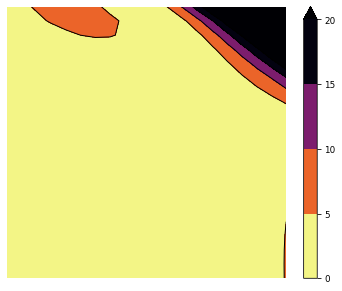

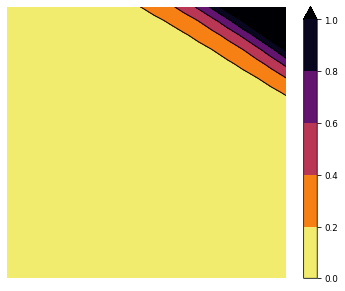

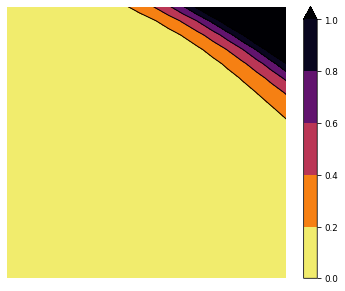

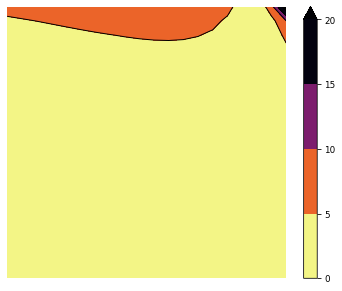

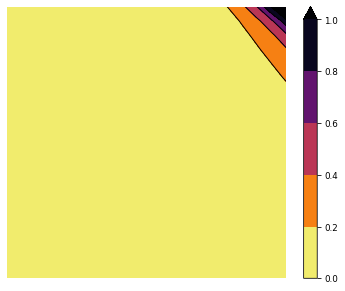

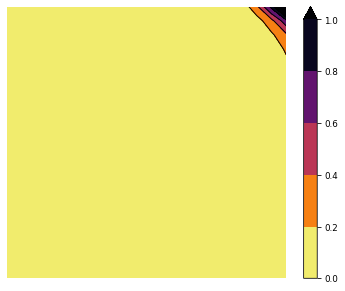

In [7]:
columns = [['B','D','F'],['H','J','L']]
for i, column in enumerate(columns):
    lm1, lm2, Psi_error, sigma_1_error, sigma_2_error = contourdata[i]
    data = [Psi_error*1000, sigma_1_error, sigma_2_error]
    levelss = [[0,20,5],[0,1.0,6],[0,1.0,6]]
    vvalues = [[2,18], [0.05,0.95], [0.05, 0.95]]
    for label,y,lev,v in zip(column,data,levelss,vvalues):
        levels = np.linspace(lev[0],lev[1],lev[2])
        vmin = v[0]
        vmax = v[1]
        fig, ax = plt.subplots(figsize=(1.25*5,5))
        ax.contour(lm1, lm2, y, colors='k', levels = levels)
        cntr1 = ax.contourf(lm1, lm2, y, cmap="inferno_r", levels = levels, vmin = vmin, vmax=vmax, extend='max')
        ax.axis('off')
        fig.colorbar(cntr1, ax=ax)
        fig.savefig('tikz_data/fig_porcine_data/fig_porcine_'+label+'.jpg', bbox_inches='tight', pad_inches=0.0)